In [58]:
import torch
import os
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn.init as init

In [59]:
class CSVDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

        self.features = self.data.iloc[:, :-1].values
        # self.labels = self.data.iloc[:, -1].values

        # self.label_encoder = LabelEncoder()
        # self.labels = self.label_encoder.fit_transform(self.labels)

        if self.transform:
            self.features = self.transform.fit_transform(self.features)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        # sample = {
        #     'features': torch.tensor(self.features[idx], dtype=torch.float32),
        #     'label': torch.tensor(self.labels[idx], dtype=torch.long)
        #     }
        sample = torch.tensor(self.features[idx], dtype=torch.float32).unsqueeze(0)
        return sample
    
    # def get_label_encoder(self):
    #     return self.label_encoder

In [60]:
def createDataLoader(train_csv, test_csv, batch_size=32):
    scaler = StandardScaler()

    train_dataset = CSVDataset(train_csv, transform=scaler)
    test_dataset = CSVDataset(test_csv, transform=scaler)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_dataset, test_dataset, train_loader, test_loader

In [61]:
train_csv = 'dataset/hars/train.csv'
test_csv = 'dataset/hars/test.csv'

train_dataset, test_dataset, train_loader, test_loader = createDataLoader(train_csv, test_csv)

In [62]:
print(len(train_dataset), len(train_loader), len(test_loader))

7352 230 93


In [63]:
for x in train_loader:
    print(x.shape) # (batch_size, seq_len, input_dim)
    break

torch.Size([32, 1, 562])


In [64]:
for batch_idx, batch in enumerate(train_loader):
    print(batch.shape)
    break

torch.Size([32, 1, 562])


In [65]:
# encoded_labels = [0, 1, 2, 3, 4, 5]  # Exemplo de labels codificados
# decoded_labels = train_dataset.get_label_encoder().inverse_transform(encoded_labels)
# print(decoded_labels)

In [66]:
# class VAE(nn.Module):
#     def __init__(self, input_dim, device, hidden_dim=400, latent_dim=20):
#         super(VAE, self).__init__()

#         # encoder
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, latent_dim * 2),
#             nn.ReLU()
#             )
        
#         # latente mean and variance
#         # self.mean_layer = nn.Linear(latent_dim, 2)
#         # self.logvar_layer = nn.Linear(latent_dim, 2)

#         # decoder
#         self.decoder = nn.Sequential(
#             nn.Linear(latent_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, input_dim),
#             # nn.Sigmoid()
#             nn.ReLU()
#         )
    
#     # def encode(self, x):
#     #     x = self.encoder(x)
#     #     return self.mean_layer(x), self.logvar_layer(x)
    
#     def reparameterization(self, mean, var):
#         std = torch.exp(0.5 * var)
#         eps = torch.randn_like(std)
#         return mean + eps * std
#         # epsilon = torch.randn_like(var).to(device)
#         # return mean + var * epsilon
    
#     # def decode(self, x):
#     #     return self.decoder(x)
    
#     def forward(self, x):
#         z_mean_logvar = self.encoder(x)
#         mean, logvar = torch.chunk(z_mean_logvar, 2, dim=-1)
#         z = self.reparameterization(mean, logvar)
#         x_hat = self.decoder(z)
#         return x_hat, mean, logvar

In [67]:
class TemporalVAE(nn.Module):
    def __init__(self, device, input_dim, hidden_dim, latent_dim, num_layers=1):
        super(TemporalVAE, self).__init__()

        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True, dropout=0.2)
        self.hidden2mean = nn.Linear(hidden_dim, latent_dim)
        self.hidden2logvar = nn.Linear(hidden_dim, latent_dim)
        
        self.latent2hidden = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True, bidirectional=False, dropout=0.2)
        self.output_layer = nn.Linear(input_dim, input_dim)
        self.dropout = nn.Dropout(0.2)
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std).to(device)
        return mean + eps * std
    
    def encode(self, x):
        residual = x
        output, (h_n, _) = self.encoder_lstm(x)
        output = output[:, :, :output.size(2)//2] + output[:, :, output.size(2)//2:]
        h_n = output[:, -1, :]
        # h_n = h_n[-1, :, :]
        h_n = self.dropout(h_n)
        mean = self.hidden2mean(h_n) # sigmoid (obs: se usar relu vai zerar)
        logvar = self.hidden2logvar(h_n) # sigmoid (obs: se usar relu vai zerar)
        return mean, logvar, residual
    
    def decode(self, z, seq_len, residual):
        # hidden = self.latent2hidden(z).unsqueeze(0).repeat(seq_len, 1, 1).transpose(0, 1)
        hidden = self.latent2hidden(z).unsqueeze(1).repeat(1, seq_len, 1)

        output, _ = self.decoder_lstm(hidden)
        output = self.dropout(output)

        # output += residual

        output = self.output_layer(output)
        return output
    
    def forward(self, x):
        mean, logvar, residual = self.encode(x)
        # print(mean)
        z = self.reparameterize(mean, logvar)
        seq_len = x.size(1)
        recon_x = self.decode(z, seq_len, residual)
        return recon_x, mean, logvar

In [68]:
# Definir parâmetros do modelo
input_dim = train_dataset.features.shape[1]
hidden_dim = 128 # 400
latent_dim = 64 # 20
num_layers = 2
learning_rate = 0.001
# batch_size = 32
epochs = 100

print(input_dim)

562


In [69]:
def loss_function(x, x_hat, mean, log_var):
    # reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum') # mse
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [70]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                init.orthogonal_(param.data)
            elif 'bias' in name:
                init.zeros_(param.data)

In [71]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # cuda
device = torch.device('cpu') # essa linha só está aqui para fazer o model.apply() funcionar, porque tem uma funcao de inicializacao que nao funciona no MPS atualmente
print(device)

# model = VAE(input_dim, device).to(device) # baseline
model = TemporalVAE(device, input_dim, hidden_dim, latent_dim, num_layers).to(device)
model.apply(init_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

cpu


In [72]:
print(model)

TemporalVAE(
  (encoder_lstm): LSTM(562, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (hidden2mean): Linear(in_features=128, out_features=64, bias=True)
  (hidden2logvar): Linear(in_features=128, out_features=64, bias=True)
  (latent2hidden): Linear(in_features=64, out_features=128, bias=True)
  (decoder_lstm): LSTM(128, 562, num_layers=2, batch_first=True, dropout=0.2)
  (output_layer): Linear(in_features=562, out_features=562, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [73]:
def evaluate_metrics(x, recon_x):
    x = x.view(-1).detach().cpu().numpy()
    recon_x = recon_x.view(-1).detach().cpu().numpy()
    
    mse = mean_squared_error(x, recon_x)
    mae = mean_absolute_error(x, recon_x)
    rmse = mse ** 0.5
    r2 = r2_score(x, recon_x)
    
    return mse, mae, rmse, r2

def train_vae(model, train_loader, optimizer, device):
    model.train()
    overall_loss = 0
    mse_total = 0
    mae_total = 0
    rmse_total = 0
    r2_total = 0
    for x in train_loader:
        data = x.to(device)
        optimizer.zero_grad()
        x_hat, mean, log_var = model(data)
        loss = loss_function(data, x_hat, mean, log_var)
        loss.backward()
        optimizer.step()
        overall_loss += loss.item()
        mse, mae, rmse, r2 = evaluate_metrics(data, x_hat)
        mse_total += mse
        mae_total += mae
        rmse_total += rmse
        r2_total += r2
    avg_train_loss = overall_loss / len(train_loader.dataset)
    avg_mse = mse_total / len(train_loader.dataset)
    avg_mae = mae_total / len(train_loader.dataset)
    avg_rmse = rmse_total / len(train_loader.dataset)
    avg_r2 = r2_total / len(train_loader.dataset)
    return avg_train_loss, avg_mse, avg_mae, avg_rmse, avg_r2

def val_vae(model, val_loader, device):
    model.eval()
    overall_loss = 0
    mse_total = 0
    mae_total = 0
    rmse_total = 0
    r2_total = 0
    with torch.no_grad():
        for x in val_loader:
            data = x.to(device)
            x_hat, mean, log_var = model(data)
            loss = loss_function(data, x_hat, mean, log_var)
            overall_loss += loss.item()
            mse, mae, rmse, r2 = evaluate_metrics(data, x_hat)
            mse_total += mse
            mae_total += mae
            rmse_total += rmse
            r2_total += r2
    avg_val_loss = overall_loss / len(val_loader.dataset)
    avg_mse = mse_total / len(train_loader.dataset)
    avg_mae = mae_total / len(train_loader.dataset)
    avg_rmse = rmse_total / len(train_loader.dataset)
    avg_r2 = r2_total / len(train_loader.dataset)
    return avg_val_loss, avg_mse, avg_mae, avg_rmse, avg_r2

In [74]:
def train(model, optimizer, epochs, device):
    train_losses = []
    val_losses = []
    
    train_mse = []
    train_mae = []
    train_rmse = []
    train_r2 = []

    val_mse = []
    val_mae = []
    val_rmse = []
    val_r2 = []
    for epoch in range(epochs):
        train_loss, mse_train, mae_train, rmse_train, r2_train = train_vae(model=model, train_loader=train_loader, optimizer=optimizer, device=device)
        val_loss, mse_val, mae_val, rmse_val, r2_val = val_vae(model=model, val_loader=test_loader, device=device)
        train_losses.append(train_loss)
        train_mse.append(mse_train)
        train_mae.append(mae_train)
        train_rmse.append(rmse_train)
        train_r2.append(r2_train)

        val_losses.append(val_loss)
        val_mse.append(mse_val)
        val_mae.append(mae_val)
        val_rmse.append(rmse_val)
        val_r2.append(r2_val)
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train MSE: {mse_train}, Val MSE: {mse_val}, Train MAE: {mae_train}, Val MAE: {mae_val}, Val R2: {r2_val}')
    return train_losses, val_losses, val_losses, train_mse, train_mae, train_rmse, train_r2, val_mse, val_mae, val_rmse, val_r2

In [75]:
train_losses, val_losses, val_losses, train_mse, train_mae, train_rmse, train_r2, val_mse, val_mae, val_rmse, val_r2 = train(model, optimizer, epochs, device)

Epoch [1/100], Train Loss: 302.5474, Val Loss: 270.5233, Train MSE: 0.01627382826591083, Val MSE: 0.005892347264730892, Train MAE: 0.014063169192664642, Val MAE: 0.005496684157809443, Val R2: 0.006685651441523248
Epoch [2/100], Train Loss: 254.3787, Val Loss: 254.8478, Train MSE: 0.013573363739530981, Val MSE: 0.005716506322851897, Train MAE: 0.012365830006225844, Val MAE: 0.005180671774621108, Val R2: 0.007079104758126173
Epoch [3/100], Train Loss: 232.7979, Val Loss: 243.8348, Train MSE: 0.012360755398756012, Val MSE: 0.00529079272191854, Train MAE: 0.011736565059754223, Val MAE: 0.0050050424365276095, Val R2: 0.00731770035945552
Epoch [4/100], Train Loss: 219.8688, Val Loss: 229.0029, Train MSE: 0.011680968361171986, Val MSE: 0.004924462376500888, Train MAE: 0.011330178439195579, Val MAE: 0.004780310269959992, Val R2: 0.007653760832204393
Epoch [5/100], Train Loss: 212.1768, Val Loss: 222.5457, Train MSE: 0.011252409866701922, Val MSE: 0.004846899574612378, Train MAE: 0.011045747149

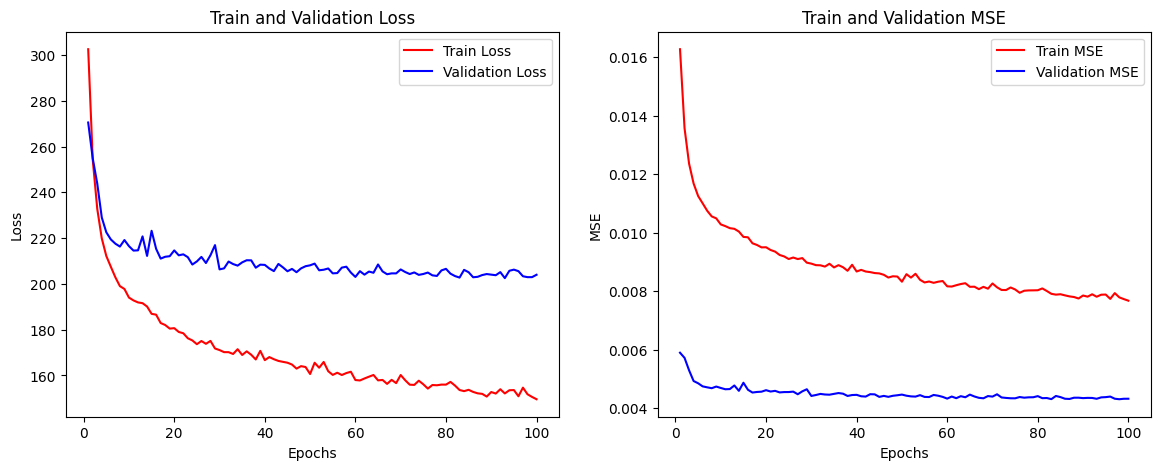

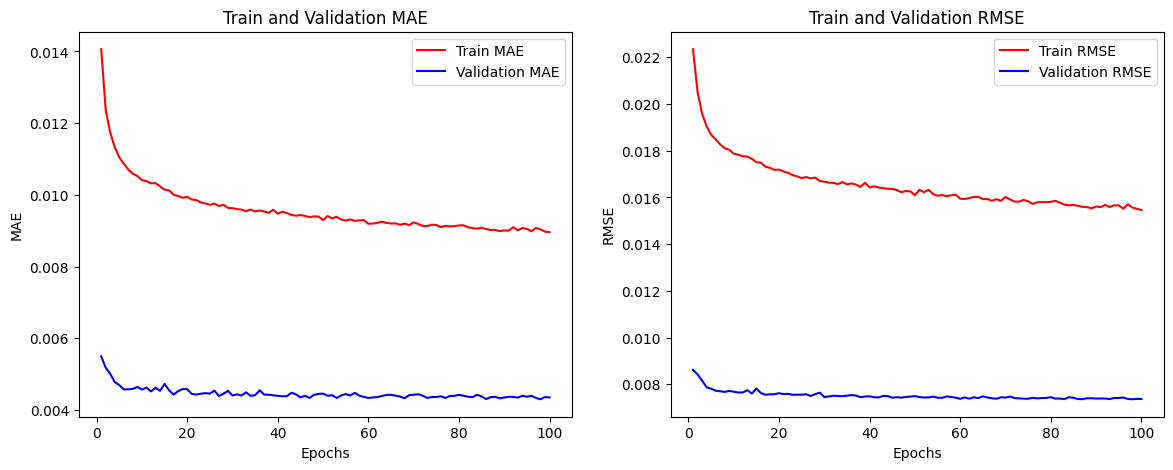

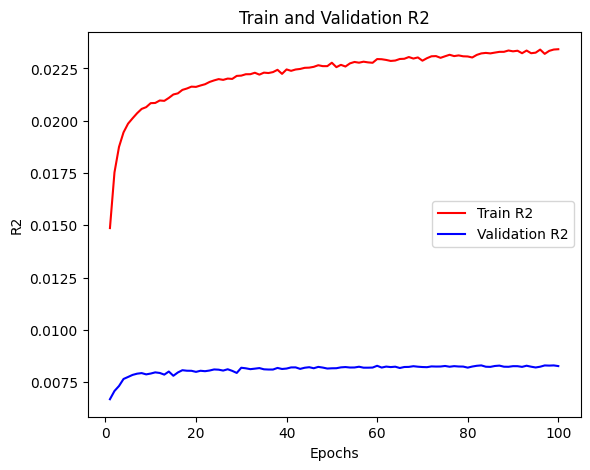

In [76]:
# Plotando a perda e a precisão do modelo sem augmentation
epocas = range(1, epochs + 1) # é 152 epocas porque com early stopping so rodou 152 epocas

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epocas, train_losses, 'r', label='Train Loss')
plt.plot(epocas, val_losses, 'b', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epocas, train_mse, 'r', label='Train MSE')
plt.plot(epocas, val_mse, 'b', label='Validation MSE')
plt.title('Train and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.show()

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epocas, train_mae, 'r', label='Train MAE')
plt.plot(epocas, val_mae, 'b', label='Validation MAE')
plt.title('Train and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epocas, train_rmse, 'r', label='Train RMSE')
plt.plot(epocas, val_rmse, 'b', label='Validation RMSE')
plt.title('Train and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.show()

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epocas, train_r2, 'r', label='Train R2')
plt.plot(epocas, val_r2, 'b', label='Validation R2')
plt.title('Train and Validation R2')
plt.xlabel('Epochs')
plt.ylabel('R2')
plt.legend()

plt.show()

In [77]:
# salvando modelo
torch.save(model.state_dict(), "model/vae.pth")

In [78]:
# carregando modelo
model_path = "model/vae.pth"

# Criar uma instância do modelo
model = TemporalVAE(device, input_dim, hidden_dim, latent_dim, num_layers).to(device)

# Carregar o estado salvo
state_dict = torch.load(model_path)

# Carregar o estado no modelo
model.load_state_dict(state_dict)

<All keys matched successfully>

Average MSE: 0.0108, Average MAE: 0.0109, Average RMSE: 0.0184, Average R²: 0.0206


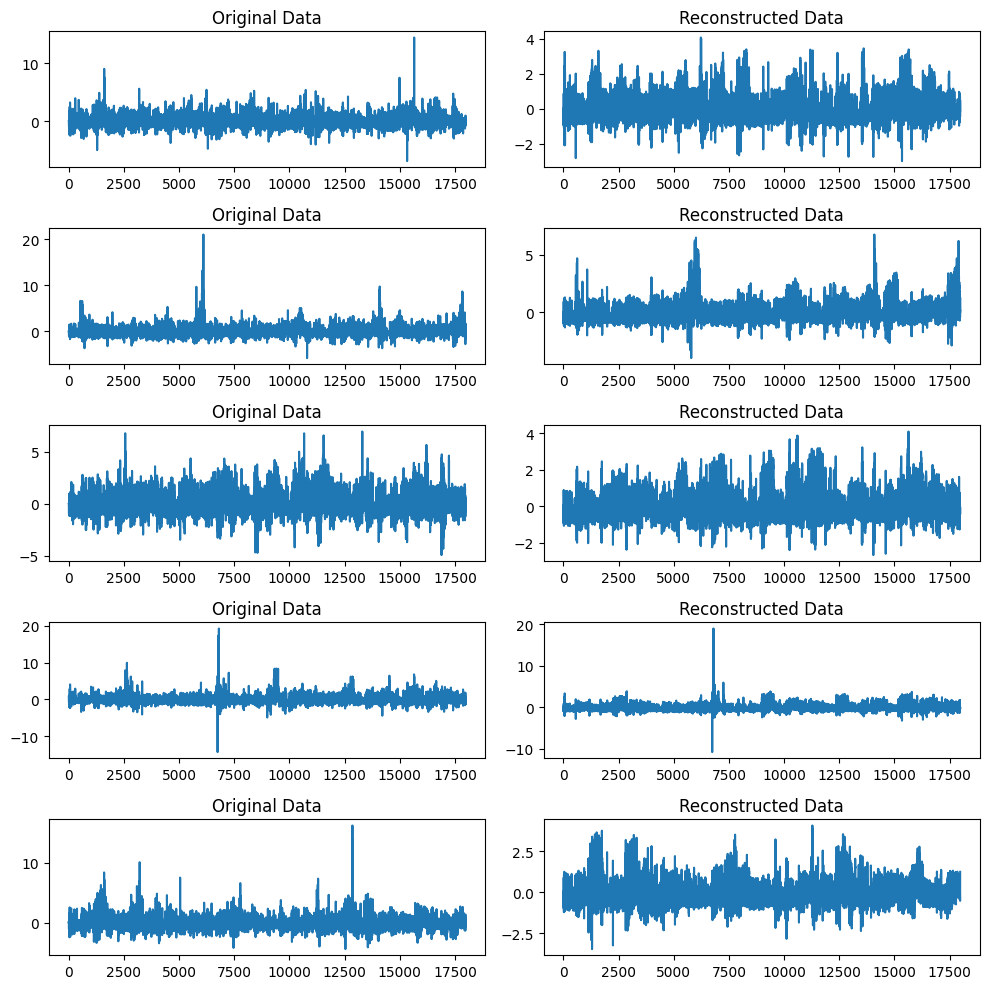

In [79]:
def evaluate_similarity(model, data_loader, device):
    model.eval()
    mse_total = 0
    mae_total = 0
    rmse_total = 0
    r2_total = 0

    with torch.no_grad():
        for x in data_loader:
            data = x.to(device)
            x_hat, _, _ = model(data)
            
            # Calcular métricas de similaridade
            mse, mae, rmse, r2 = evaluate_metrics(data, x_hat)
            mse_total += mse
            mae_total += mae
            rmse_total += rmse
            r2_total += r2

    avg_mse = mse_total / len(data_loader.dataset)
    avg_mae = mae_total / len(data_loader.dataset)
    avg_rmse = rmse_total / len(data_loader.dataset)
    avg_r2 = r2_total / len(data_loader.dataset)

    return avg_mse, avg_mae, avg_rmse, avg_r2

def plot_reconstruction(data_loader, model, device, num_samples=5):
    model.eval()
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 2 * num_samples))
    with torch.no_grad():
        for i, x in enumerate(data_loader):
            if i >= num_samples:
                break
            data = x.to(device)
            x_hat, _, _ = model(data)
            
            # original = data[0].cpu().numpy()
            # reconstructed = x_hat[0].cpu().numpy()
            original = data.view(-1).detach().cpu().numpy()
            reconstructed = x_hat.view(-1).detach().cpu().numpy()
            
            axs[i, 0].plot(original, label='Original')
            axs[i, 1].plot(reconstructed, label='Reconstructed')
            
            axs[i, 0].set_title('Original Data')
            axs[i, 1].set_title('Reconstructed Data')
    
    plt.tight_layout()
    plt.show()

avg_mse, avg_mae, avg_rmse, avg_r2 = evaluate_similarity(model, test_loader, device)
print(f'Average MSE: {avg_mse:.4f}, Average MAE: {avg_mae:.4f}, Average RMSE: {avg_rmse:.4f}, Average R²: {avg_r2:.4f}')

plot_reconstruction(test_loader, model, device)

In [80]:
# # exemplo de backbone importado para downstrem task

# import torch
# import torch.nn as nn
# import torch.optim as optim

# class Encoder(nn.Module):
#     def __init__(self, input_dim, latent_dim):
#         super(Encoder, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 128)
#         self.fc2_mu = nn.Linear(128, latent_dim)
#         self.fc2_logvar = nn.Linear(128, latent_dim)

#     def forward(self, x):
#         h = torch.relu(self.fc1(x))
#         mu = self.fc2_mu(h)
#         logvar = self.fc2_logvar(h)
#         return mu, logvar

# class Decoder(nn.Module):
#     def __init__(self, latent_dim, output_dim):
#         super(Decoder, self).__init__()
#         self.fc3 = nn.Linear(latent_dim, 128)
#         self.fc4 = nn.Linear(128, output_dim)

#     def forward(self, z):
#         h = torch.relu(self.fc3(z))
#         x_recon = torch.sigmoid(self.fc4(h))
#         return x_recon

# class VAE(nn.Module):
#     def __init__(self, input_dim, latent_dim):
#         super(VAE, self).__init__()
#         self.encoder = Encoder(input_dim, latent_dim)
#         self.decoder = Decoder(latent_dim, input_dim)

#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def forward(self, x):
#         mu, logvar = self.encoder(x)
#         z = self.reparameterize(mu, logvar)
#         x_recon = self.decoder(z)
#         return x_recon, mu, logvar

# def loss_function(recon_x, x, mu, logvar):
#     BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return BCE + KLD

# # Hyperparameters
# input_dim = 100  # Exemplo, altere de acordo com os seus dados
# latent_dim = 20
# learning_rate = 0.001
# num_epochs = 50

# # Model, optimizer
# vae = VAE(input_dim, latent_dim)
# optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# # Training loop
# for epoch in range(num_epochs):
#     for x in data_loader:  # Assumindo que você tem um data_loader definido
#         optimizer.zero_grad()
#         x_recon, mu, logvar = vae(x)
#         loss = loss_function(x_recon, x, mu, logvar)
#         loss.backward()
#         optimizer.step()
#     print(f'Epoch {epoch}, Loss: {loss.item()}')

# class ActivityClassifier(nn.Module):
#     def __init__(self, encoder, latent_dim, num_classes):
#         super(ActivityClassifier, self).__init__()
#         self.encoder = encoder
#         self.fc = nn.Linear(latent_dim, num_classes)

#     def forward(self, x):
#         mu, logvar = self.encoder(x)
#         return self.fc(mu)  # Utilizando mu como a representação latente

# # Hyperparameters
# num_classes = 10  # Exemplo, altere conforme necessário
# learning_rate = 0.001
# num_epochs = 50

# # Model, optimizer
# activity_classifier = ActivityClassifier(vae.encoder, latent_dim, num_classes)
# optimizer = optim.Adam(activity_classifier.parameters(), lr=learning_rate)
# criterion = nn.CrossEntropyLoss()

# # Training loop for the downstream task
# for epoch in range(num_epochs):
#     for x, y in labeled_data_loader:  # Assumindo que você tem um labeled_data_loader definido
#         optimizer.zero_grad()
#         logits = activity_classifier(x)
#         loss = criterion(logits, y)
#         loss.backward()
#         optimizer.step()
#     print(f'Epoch {epoch}, Loss: {loss.item()}')